In [29]:
import functools
import operator
import string

import joblib
import textblob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.decomposition import NMF
# from sklearn.decomposition import TruncatedSVD as LSA
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline

In [2]:
# sns.set(style="whitegrid")
sns.set(style="darkgrid")

In [3]:
X = pd.read_csv('quora_challenge.csv')

In [4]:
# the vast majority of questions are short texts
X['question_text'].str.len().describe()

count    983801.000000
mean         68.881823
std          36.746332
min           5.000000
25%          44.000000
50%          59.000000
75%          83.000000
max         752.000000
Name: question_text, dtype: float64

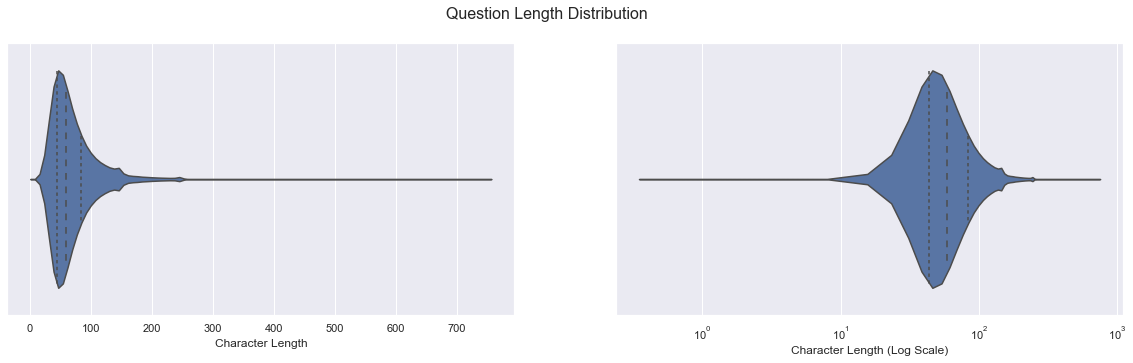

In [5]:
X['question_len'] = X['question_text'].str.len()

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.suptitle('Question Length Distribution', fontsize=16)

sns.violinplot(X['question_len'], inner='quartile', orient='h', ax=ax0)
ax0.set_xlabel('Character Length')

sns.violinplot(X['question_len'], inner='quartile', orient='h', ax=ax1)
ax1.set_xscale('log')
ax1.set_xlabel('Character Length (Log Scale)');

In [6]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, *, target_col='question_text', result_col='cleaned_text', pos='anvr', stop_words=None):
        self.target_col = str(target_col)
        self.result_col = str(result_col)
        self.pos = tuple(pos.lower()) if isinstance(pos, str) else tuple(pos)
        self.stop_words = () if stop_words is None else frozenset(stop_words)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.result_col] = (X[self.target_col].str.lower()
                                                .map(self.asciitize)
                                                .map(self.depunctuate)
                                                .map(self.lemmatize))
        return X[self.result_col].values
        
    @staticmethod
    def asciitize(text):
        return ''.join(char for char in text if char in string.printable)

    @staticmethod
    def depunctuate(text):
        return ''.join(char if char not in string.punctuation else ' ' for char in text)
    
    def lemmatize(self, text):
        tag_dict = dict(J='a', N='n', V='v', R='r')
        blob = textblob.TextBlob(text)
        
        try:
            words, tags = zip(*blob.pos_tags)
        except ValueError:
            return ''
        
        tags = (tag_dict.get(tag[0]) for tag in tags)
        lemmas = (word.lemmatize(tag) for word, tag in zip(words, tags)
                  if tag in self.pos
                  if word not in self.stop_words)
        result = ' '.join(lem for lem in lemmas if lem not in self.stop_words)
        return result if result else ' '

In [7]:
EXTRA_STOP_WORDS = frozenset("does doesn doesnt don dont im ive make quora really shouldnt youll ve weve wouldnt".split())
NOT_STOP_WORDS = frozenset("cry system".split())
CUSTOM_STOP_WORDS = ENGLISH_STOP_WORDS | EXTRA_STOP_WORDS - NOT_STOP_WORDS

In [8]:
try:
    X = pd.read_pickle('X_clean.pkl')
except Exception:
    TextPreprocessor(stop_words=CUSTOM_STOP_WORDS).fit_transform(X)
    X.to_pickle('X_clean.pkl')

In [646]:
vector_kwds = dict(
    ngram_range=(1, 2),
    stop_words=None,
    lowercase=False,
    max_df=0.9,
    max_features=25_000,
)

decomp_kwds = dict(
    n_components=50,
    random_state=0,
)

topic_model_pipe = Pipeline([
#     ('textprep', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(**vector_kwds)),
    ('decomposer', NMF(**decomp_kwds)),
], verbose=True)

In [647]:
# X_new = topic_model_pipe.fit_transform(X)
# file_prefix = '_'.join(type(step).__name__ for step in topic_model_pipe.named_steps.values()).lower()

In [648]:
X_new = topic_model_pipe.fit_transform(X['cleaned_text'])

file_prefix = ('_'.join(type(step).__name__ for step in topic_model_pipe.named_steps.values()).lower()
               + f'_topics{topic_model_pipe["decomposer"].n_components}'
               + f'_mxfeat{topic_model_pipe["vectorizer"].max_features}'
              )
print(file_prefix)

joblib.dump(topic_model_pipe, f'{file_prefix}__pipeline.joblib')
joblib.dump(X_new, f'{file_prefix}__X_new.joblib');

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=  24.5s
[Pipeline] ........ (step 2 of 2) Processing decomposer, total=12.3min


'tfidfvectorizer_nmf_topics50_mxfeat25000'

In [728]:
# Get top words for each category -- does not need X
n_top = 8

feature_names = topic_model_pipe['vectorizer'].get_feature_names()
pyfunc = functools.partial(operator.getitem, feature_names)
vfunc = np.vectorize(pyfunc)

components = topic_model_pipe['decomposer'].components_
word_idxs = components.argsort(axis=1)[:, -n_top:][:, ::-1]
words = vfunc(word_idxs)

top_words_df = pd.DataFrame(words.T, columns=[f'Topic {i}' for i in range(len(words))])
top_words_df.index.name = 'Top Words'

# top_words_df.to_csv('top_words.csv')
joblib.dump(top_words_df, f'{file_prefix}__top_words.joblib')

top_words_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 40,Topic 41,Topic 42,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49
Top Words,,,,,,,,,,,,,,,,,,,,,
0,best,people,use,good,know,mean,year,difference,india,work,...,movie,example,woman,girl,live,say,possible,long,come,company
1,best way,people think,word,idea,best know,dream,old,main,china,start work,...,game,real,men,guy,place,people say,number,term,meaning,buy
2,place,hate,people use,good bad,fact,word,year old,main difference,pakistan,tip,...,watch,good example,man,look,people live,word,phone,relationship,word,big
3,best place,people say,instead,good idea,people know,mean say,experience,similarity,buy,tip start,...,play,human,sex,boy,human,trump,account,long term,new,software
4,best book,believe,method,good way,need know,mean dream,old girl,major,indian,useful,...,video,best example,indian,like,live life,mean say,human,long time,true,product
5,best thing,people use,app,place,know fact,mean guy,age,similarity difference,scope,useful tip,...,favorite,great,men woman,date,best place,just,create,stay,idea,service
6,best friend,people know,software,good place,want know,guy,old boy,major difference,cost,hard,...,tv,animal,date,indian,city,thing say,mobile,distance,child,new
7,website,people hate,technique,good book,thing know,term,year ago,whats difference,company india,experience,...,download,food,child,sex,place live,tell,phone number,effect,power,car


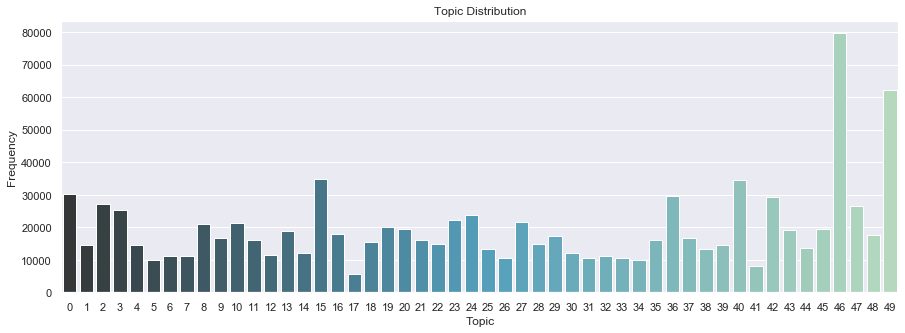

In [729]:
# Get topic count distribution
topics = np.argmax(X_new, axis=1)
x, y = np.vstack(np.unique(topics, return_counts=True))

plt.figure(figsize=(15, 5))
sns.barplot(x, y, palette='GnBu_d')
plt.title('Topic Distribution')
plt.xticks(ticks=range(len(x)))
plt.xlabel('Topic')
plt.ylabel('Frequency')

plt.savefig(f'{file_prefix}__topic_dist.png');

In [731]:
# Label sentences to their best topic & corresp weight
X['topic'] = np.argmax(X_new, axis=1)
X['weight'] = np.max(X_new, axis=1)

joblib.dump(X, f'{file_prefix}__X_clean_topic.joblib');

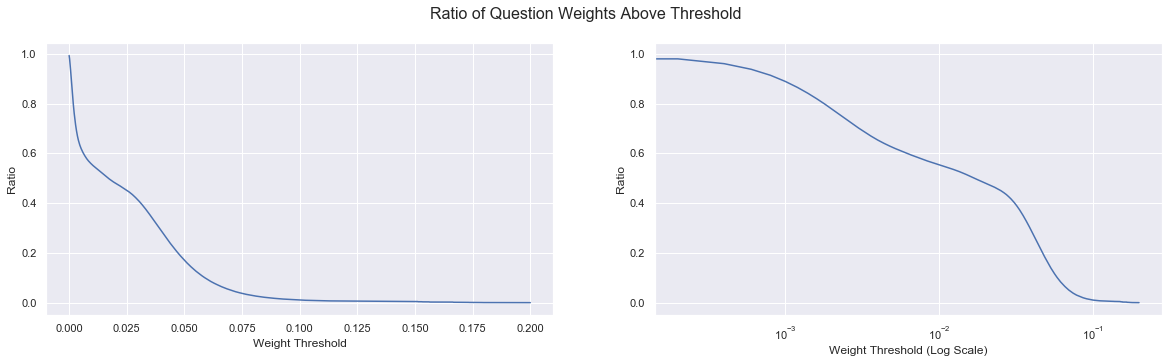

In [732]:
stop = np.ceil(X['weight'].max() * 100) / 100
xs = np.linspace(0, stop, 1000)
ys = np.empty_like(xs)
for i, x in enumerate(xs):
    ys[i] = np.sum(X['weight'] > x) / len(X)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.suptitle('Ratio of Question Weights Above Threshold', fontsize=16)

ax0.plot(xs, ys)
ax0.set_xlabel('Weight Threshold')
ax0.set_ylabel('Ratio')

ax1.plot(xs, ys)
ax1.set_xscale('log')
ax1.set_xlabel('Weight Threshold (Log Scale)')
ax1.set_ylabel('Ratio')

plt.savefig(f'{file_prefix}__thresh_ratio.png');

In [661]:
# checking out likelihoods that a question should be classified as a topic
# may want a threshold for topics / allow for multiple topics if numbers are relatively close


# good examples with 20k, 40topcs
# 8, -7, -4

In [692]:
gt = X['weight'] > 0.1
gt.sum() / len(probs)

0.010457399413092688

In [663]:
np.max(X_new, axis=1)[-10:]

array([0.03780704, 0.04737293, 0.00570236, 0.04683006, 0.04771006,
       0.00420799, 0.07910832, 0.03423751, 0.02040722, 0.00699635])

In [679]:
i = -7

In [680]:
np.sort(X_new[i])[::-1].round(4)

array([0.0468, 0.0162, 0.0005, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    ])

In [681]:
idxs = np.argsort(X_new[i])[::-1].round(4)
idxs

array([42,  0, 40,  3, 12, 21, 20, 19, 18, 17, 16, 15, 14, 13, 10, 11, 23,
        9,  8,  7,  6,  5,  4,  2,  1, 22, 49, 48, 36, 47, 46, 45, 44, 43,
       41, 39, 38, 37, 35, 25, 34, 33, 32, 31, 30, 29, 28, 27, 26, 24])

In [682]:
X['question_text'].values[i]

"Why aren't any women among the best 100 chess players?"

In [683]:
top_words_df.iloc[:, idxs[:3]]

,Topic 42,Topic 0,Topic 40
Top Words,,,
0,woman,best,movie
1,men,best way,game
2,man,place,watch
3,sex,best place,play
4,indian,best book,video
5,men woman,best thing,favorite
6,date,best friend,tv
7,child,website,download


In [733]:
X

,question_text,question_len,cleaned_text,topic,weight
0,How did Quebec nationalists see their province...,72,quebec nationalist province nation 1960s,35,0.001135
1,"Do you have an adopted dog, how would you enco...",81,adopt dog encourage people adopt shop,1,0.013796
2,Why does velocity affect time? Does velocity a...,67,velocity affect time velocity affect space geo...,12,0.026248
3,How did Otto von Guericke used the Magdeburg h...,57,otto von guericke use magdeburg hemisphere,2,0.035658
4,Can I convert montra helicon D to a mountain b...,77,convert montra helicon d mountain bike just ch...,34,0.038002
...,...,...,...,...,...
983796,What info does a Facebook page receive when yo...,62,info facebook page receive page,46,0.004208
983797,"If no can know God, why believe in something y...",61,know god believe know,4,0.079108
983798,Is it true that the lunar cycle affects women'...,65,true lunar cycle affect woman s menstrual cycle,42,0.034238
983799,What is the difference between the old currenc...,135,difference old currency note r rs new currency...,7,0.020407


In [4]:
# Get top representative sentences
n_sents = 8
repr_idxs = np.argsort(X_new, axis=0)[-n_sents:].T
repr_sents = X['question_text'].values[repr_idxs]

joblib.dump(repr_sents, f'{file_prefix}__repr_sents.joblib');

NameError: name 'X_new' is not defined

In [22]:
for i, (idxs, sents) in enumerate(zip(repr_idxs, repr_sents)):
    print(f'Topic {i}')
    for idx, sent in zip(idxs, sents):
        print('\t', X['weight'][idx].round(4), sent)
    print('-' * 100)

Topic 0
	 0.0766 Who is the best gynaecologist?
	 0.0766 Who is the best humanist?
	 0.0766 How can I become the best at something?
	 0.0766 What is the best ravioli?
	 0.0766 What are the best parts about motherhood?
	 0.0766 What is the best Jabbawockeez hoodie?
	 0.0766 What is the best clearinghouse?
	 0.0766 What are the best Cozumel excursions?
----------------------------------------------------------------------------------------------------
Topic 1
	 0.0679 Why are ambidextrous people synesthetic?
	 0.0679 Why do some people have 3 godparents?
	 0.0679 Why are people so ticklish?
	 0.0679 Can people on Quora see if you've downvoted them?
	 0.0679 What is so appealing to people about QANON?
	 0.0679 Why am I judged and underestimated by many people?
	 0.0679 How do people not now it yet?
	 0.0679 Why do people like Sephiroth so much?
----------------------------------------------------------------------------------------------------
Topic 2
	 0.153 What can I use as a footrest?

In [735]:
# TODO: display the probas alongside sents

# Random selected topic sents
samples = []
for i in range(topic_model_pipe['decomposer'].n_components):
    try:
        sample = X[X['topic'] == i]['question_text'].sample(5, random_state=0)
    except ValueError:
        sample = [None]
    samples.append(sample)
    print(f'Topic {i}')
    for j, sent in sample.iteritems():
        print('\t', X['weight'][j].round(4), sent)
    print('-' * 100)

joblib.dump(samples, f'{file_prefix}__samples.joblib');

Topic 0
	 0.0195 Which is the best insurer for health policy?
	 0.0191 Which is best for looking FZ or Avenger?
	 0.0145 What crypto currency is cheaper and best to invest for 2018?
	 0.0249 Who is the best neuropathy doctor in Patna?
	 0.0245 Which are the best second bananas of superhero teams? (the lancers with the best leadership skills for when the leader is absent)?
----------------------------------------------------------------------------------------------------
Topic 1
	 0.0131 Do people with normal blood pressure get affected by cold weather?
	 0.0296 Are black people more muscular than white people?
	 0.0288 How would the new knowledge of Obama people surveilling Trump people be substantially different from Watergate?
	 0.0174 How do people act in a catastrophe?
	 0.0334 Why do people attend 'megachurches' like Hillsong and C3?
----------------------------------------------------------------------------------------------------
Topic 2
	 0.0007 Can we replace LT Motors with 

Topic 19
	 0.0012 How does Jollibee's chickenjoy compare to other restaurant's?
	 0.0033 Do the majority of European citizens exhibit monosexual attraction?
	 0.0026 Why were the European governments driven by the spirit of conservatism?
	 0.0006 What part of Italy did the Taliaferros originate from?
	 0.0319 Is US Government sending GMO food as humanitarian aid to various countries?
----------------------------------------------------------------------------------------------------
Topic 20
	 0.0026 What makes preparing for IITs worth it?
	 0.0006 How did Daniel Dwayne "Diggy" Simmons III become a successful singer?
	 0.0122 How does the enterprise rent-a-car business model fit in with the American Core Value of freedom of choice?
	 0.051 What is the starting system of Maruti gypsy?
	 0.0522 How fast can someone earn their PhD, starting at associates?
----------------------------------------------------------------------------------------------------
Topic 21
	 0.0761 What is the answ

Topic 38
	 0.0035 Will Mindtree Revoke my Offer letter if I dont have 65% in my academics?
	 0.0023 How much does it cost to publish a research paper?
	 0.0008 What is the anchoring script for freedom?
	 0.0056 What is your happy story for today?
	 0.0368 What do I write in the subject of my first email to a professor that may accept me as his graduate student?
----------------------------------------------------------------------------------------------------
Topic 39
	 0.0371 How much postage do I need to send a regular 1st class mail to India?
	 0.1101 I have Quora, do I still need a book?
	 0.0444 How many days needed to prepare for Jee?
	 0.0533 How many knives does the average home cook need?
	 0.0009 How do some plants extract nutrients from coffee grounds?
----------------------------------------------------------------------------------------------------
Topic 40
	 0.0084 What is your experience with monthly videos for marketing?
	 0.0029 You are producing a horror film for ca

In [5]:
import joblib

file_prefix = 'tfidfvectorizer_nmf_topics50_mxfeat25000'
X = joblib.load(f'{file_prefix}__X_clean_topic.joblib')

X_new = joblib.load(f'{file_prefix}__X_new.joblib')

In [8]:
n_sents = 8
repr_idxs = np.argsort(X_new, axis=0)[-n_sents:].T
repr_sents = X['question_text'].values[repr_idxs]
# repr_sents
repr_idxs[48]

array([446170, 336102, 884936, 820825, 882237, 966933, 129820, 340205])

In [20]:
res = X[['question_text', 'weight', 'topic']]
# np.take_along_axis(res, repr_idxs)
res.values[repr_idxs[48]]
# res.shape, repr_idxs[48].shape
# .iloc[repr_idxs]
# .values[repr_idxs]

array([['What comes next 13:1131::8:?', 0.17947867133730067, 48],
       ['Did Eustace from Narnia come back?', 0.17947867133730067, 48],
       ['Where did Magyars come from?', 0.17947867133730067, 48],
       ['Which comes down but never goes up?', 0.17947867133730067, 48],
       ['Will Darrio come back?', 0.17947867133730067, 48],
       ['Where did catechism come from?', 0.17947867133730067, 48],
       ['Has anyone been to purgatory and come back?',
        0.17947867133730067, 48],
       ['Where does Azdome come from?', 0.17947867133730067, 48]],
      dtype=object)

In [3]:
mask = X['topic'] == 48
X[mask]['weight'].max()

0.17947867133730067

Topic 48
	 0.045 What comes next 13:1131::8:?
	 0.045 Did Eustace from Narnia come back?
	 0.045 Where did Magyars come from?
	 0.045 Which comes down but never goes up?
	 0.045 Will Darrio come back?
	 0.045 Where did catechism come from?
	 0.045 Has anyone been to purgatory and come back?
	 0.045 Where does Azdome come from?



Topic 48
	 0.0 What is a redneck pudding?
	 0.0546 Should Jesus come again (of course, in a new body), how would you recognize him and how would you "persecute" him?
	 0.0067 From which the word geography derived?
	 0.0543 Do relationships always come with an expiry date?
	 0.0503 Is it weird to ask your partner if he or she has STD before having sex? Or does will come off as paranoid?

Topic 46
	 0.0249 Is anything possible?
	 0.0249 Is it possible to not be relatable to anyone?
	 0.0249 Was vegetarianism possible back then?
	 0.0249 Is 0.3mm possible?
	 0.0249 Is 1+1=1 possible? Why?
	 0.0249 Is it possible to get 1000 on Quizizz?
	 0.0249 What are the possible investissements to make with 50€-100€?
	 0.0249 Is it possible to make myself not oblivious?



Topic 46
	 0.0025 What is the function of the occipital lobe in the brain?
	 0.0371 How do we get SBI bank account numbers verified at bulk?
	 0.0299 What are some possible winter internship opportunities for international students in NYC?
	 0.0005 What are endangered species in Indonesia?
	 0.0003 How do you find a sample median?

Topic 16
	 0.0517 What would happen when there is no inosphere?
	 0.0517 What would happen if you took 30, 36mg of Concerta at once?
	 0.0517 What happened to Hari Madhavan?
	 0.0517 How do vesicular murmurs happen?
	 0.0517 What happened to Avicii?
	 0.0517 What would happen if there was no varna system?
	 0.0517 What happened to Fabian Cancellara?
	 0.0517 What happens if I take 30 panadol at once?



Topic 16
	 0.0536 What happens if you took an antipsychotic drug accidentally? What must be done?
	 0.0374 What happens when you look in the eye and have a firm hand shake?
	 0.0378 I have the same dream every night where an angel shows me things that end up happening the next day, what should I do?
	 0.0279 What happens to the electrical potential energy when a unit positive charge moves from low to high potential region?
	 0.0543 What happen to people when they die?